# Neural nets

Welcome to the third jupyter notebook! In this session, we'll cover some basics about neural nets. If it looks like you're gonna be through the content of this notebook in ten minutes or so, because you're already familiar with all of its concepts, then feel free to challenge yourself a little more with the overarching machine-learning challenge.

## Setup

To allow the next code blocks to run smoothly, this section sets a couple of settings.

Some imports that we will be using:

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

And some more imports specific to this notebook:

In [2]:
import tensorflow as tf
from tensorflow import keras

Some figure plotting settings: increase the axis labels of our figures a bit.

In [3]:
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Preparing the input data

We've already touched it previously, but one of the most popular (and probably most boring) datasets using in machine-learning teaching is the MNIST dataset. It's a collection of pictures of handwritten digits. We'll use it to train some neural nets in this session! First, we'll need to fetch the dataset from the internet. Then, we'll have to transform it in such a way that it can be used with our model.

Let's start with downloading the dataset, which already comes in two sets for training and testing:

In [4]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

To understand what we're dealing with, let's check the shape of the objects:

In [5]:
X_train_full.shape

(60000, 28, 28)

Ok, great! Our training dataset consists of 60,000 instances, each of which has 28 by 28 features. Since we're talking about images, these 28 by 28 features are just the pixels of the image. And the test dataset?

In [6]:
X_test.shape

(10000, 28, 28)

That's 10,000 instances, good. When dealing with images, the individual pixels can carry different types of information: in the worst case, three different colour channels (red, blue, green), each of which with a certain "depth" (that is, the number of bits used to "describe" the colour). 8 or 16 bits are typical numbers for this. The first case, for example, would mean that we can have 256 different colour intensities ($2^{8}$). Luckily, our images are only greyscale, so each pixel only carries 8 bits to describe its brightness. Let's scale this to be between 0 and 1:

In [7]:
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0

In addition, we should reserve a small fraction of the training data for validation. Remember the three different types of datasets we usually consider when building/fitting/validating/testing a model:
* The training data, which is directly used in the training steps of the model.
* The validation data, which is used to evaluate the model performance on-the-fly during training. Validation data does _not_ go into the fit procedure itself, but it does have an impact on the training procedure. For example, when using techniques like early stopping, the model performance on the validation data is the deciding factor when to stop training.
* The test data, which the model _only_ gets to see once it is fully built and trained. This is to check how the model performs on unseen data.

We've already separated our dataset into 60,000 training and 10,000 testing instances, but let's reserve another fraction of the training data for on-the-fly validation purposes. We'll split into 55,000 training and 5,000 testing instances.

In [8]:
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

Before we get started with building a model and the training, let's have a quick look at the data itself. The following block of code picks one random instance (no. 36,000), rehapes it into an image and prints it to your screen:

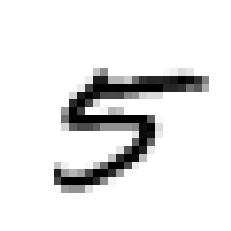

In [9]:
some_digit = X_train[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary,
           interpolation="nearest")
plt.axis("off")
plt.show()

Look's very much like a five, doesn't it? Let's look at a bunch of instances.

In [10]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

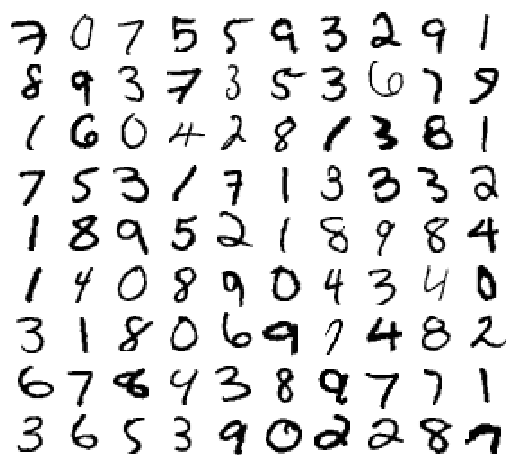

In [11]:
plt.figure(figsize=(9,9))
example_images = np.r_[X_train[::612]]
plot_digits(example_images, images_per_row=10)
plt.show()

Cool! We can already see that most of them are easy to classify with the human eye, but there are a few instances that are quite tricky. You'll also notice that almost all digits were written by Americans, they would look different if put down by a German native speaker.

## Building a feed-forward neural net

We're ready to set up our first model. So far, we've only been using the Scikit Learn package, which comes with many functions, models etc. already implemented. It's a great tool to learn the basics of machine learning. However, when it comes to neural nets, we'll move to [tensorflow](https://www.tensorflow.org/). Tensorflow is an open-source machine-learning library developed by Google and is being used widely. It's very powerful in converting relatively simple models defined by the user into complex, but optimised computing operations. This works you own laptops, large-scale computing centres, GPUs, CPUs, and even your mobile phones.

Tensorflow used to have it's own syntax and functions to create models, what software engineers would call an API ("application programming interface"). Quite recently, they have moved to encouraging everyone to use [keras](https://keras.io) as the API of choice. Keras is an independent library, but is also shipped as part of tensorflow. We've already imported both tensorflow and Keras (from tensorflow) in one of the earlier cells.

Enough reading, let's get some model running. The following lines of commands set up a very simple feed-forward neural net:

In [12]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

W0905 11:43:14.278211 4662363584 deprecation.py:506] From /Users/knut/anaconda3/envs/ml/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Just from the syntax, can you guess what the architecture of the network is? That's the great thing about Keras, the syntax is just really simple. Let's go through it step by step:
* An input layer with input shape 28x28 (these are our images with 28x28 pixels).
* A fully-connected dense layer with 300 nodes.
* An activation called "leaky ReLU", we'll come to that in a second.
* Another fully-connected dense layer with 100 nodes.
* Another "leaky ReLU" activation function.
* A fully-connected output layer with 10 nodes. The activation function is specified to be the "softmax" function.

And that's the entire model! Of course, we haven't done anything with it, but it really only takes very few lines to create powerful models in tensorflow/Keras. 

Now, what about this "leaky ReLU" function? Or to start even before that: what is an activation function? Imagine a neuron with many input connections from the previous layer. Some of them might have very small weights, some of them might be large, some of them might be positive, others negative. Literally the only thing a neuron in a network does is to sum over all of these weighted inputs. And maybe add a bias term to the result, but that's it. Now, if you remember, we're trying to mimic biological structures with these neurons, so we need some sort of "decision" whether the neuron should be activated and forward information to the next levels, too.

This is done with activation functions. The activation function takes the weighted sum of all neuron inputs (plus the bias term) and applies a pre-defined function to it. Depending on the outcome, the neuron will be activated or not. One of the quite popular functions is the _rectified linear unit_, or in short-hand: ReLU.

$$ f(x) = \max(0, x) $$

Ok, so once the weighted input is larger than zero, the function output value will be non-zero. That function is quite nice as it doesn't really require any computation (unlike taking the logarithm or something like that). But it comes with a problem known as "dying neurons": once the weighted input is below zero, the neuron will not output anything. Weights in feed-forward networks are updated through a process called _backpropagation_. But if the neuron has no forward connections, there cannot be any backpropagated gradient. Effectively, these neurons die once and (most) likely forever.

This can be overcome by a slight modification of the function: a "leak". Instead of being flattened to zero completely, we just allow a little bit of leakage. This is usually done by:

$$ f(x) = \max(\alpha x, x) \quad \text{where}~0 \leq \alpha < 1 $$

To get an idea, how this function looks like, the following code produces a plot of a leaky ReLU:

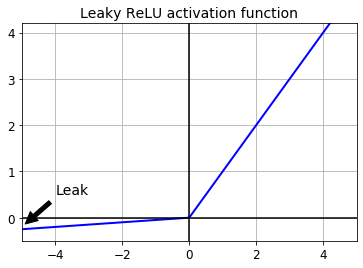

In [13]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])
plt.show()

And exactly that's the function we implemented in our model above.

Before fitting the model, we'll need to do one last step: compile it. In tensorflow/Keras slang this means to fix the model configuration for training. We'll set which loss function to use, which optimiser to use, and which metric to use to describe the model's performance:

In [14]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In this case, we chose to use _sparse categorical cross-entropy_ as our loss function. We'll skip the details here, but you can read up on that on many other places on the internet. We also chose to be conservative and just use stochastic gradient descent as our optimiser. There are many others to choose, ranging from RMSProp to ADAM.

Now, the next step is to fit the model. Be aware that this might take a moment on your laptop:

In [15]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 9s 166us/sample - loss: 1.4519 - acc: 0.6405 - val_loss: 0.9089 - val_acc: 0.7942
Epoch 2/10
55000/55000 [==============================] - 8s 152us/sample - loss: 0.7311 - acc: 0.8268 - val_loss: 0.5827 - val_acc: 0.8490
Epoch 3/10
55000/55000 [==============================] - 11s 206us/sample - loss: 0.5381 - acc: 0.8613 - val_loss: 0.4680 - val_acc: 0.8768
Epoch 4/10
55000/55000 [==============================] - 8s 151us/sample - loss: 0.4582 - acc: 0.8765 - val_loss: 0.4106 - val_acc: 0.8886
Epoch 5/10
55000/55000 [==============================] - 14s 247us/sample - loss: 0.4139 - acc: 0.8864 - val_loss: 0.3759 - val_acc: 0.8960
Epoch 6/10
55000/55000 [==============================] - 8s 142us/sample - loss: 0.3850 - acc: 0.8923 - val_loss: 0.3515 - val_acc: 0.9036
Epoch 7/10
55000/55000 [==============================] - 10s 181us/sample - loss: 0.3642 - acc: 0.8975 - val

Ok, done! We can also print a general summary of the model we defined: we do have quite an impressive number of trainable parameters.

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
__________________________________________________

And, eventually, we should evaluate the model performance on our test data:

In [17]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 72us/sample - loss: 0.3020 - acc: 0.9148


[0.3020229447841644, 0.9148]

Would you say this is particularly good? Or maybe there is room for improvement? Is our model too simple or too complicated for the given task? Does it overfit? Compare the values of loss and accuracy for train/validation/test data.

## Batch Normalisation

One possible way to increase the model performance is to perform batch normalisation. It's particularly helpful to increase the speed at which the model learns. Can you remember what exactly batch normalisation does? 

The following model implements two hidden layers, each of which uses the ReLU activation function again. In addition, batch normalisation is performed after each step of the calculation. Still a really simple model, isn't it?

In [18]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

Let's print another summary of the model:

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_3 (Dense)              (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

The overall number of parameters has increased slightly, but not significantly. Do you have any idea why there are some non-trainable parameters now? Again: remember what exactly the batch-normalisation layers do. Next step, compile the model once again.

In [20]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

And, eventually, fit the model to our training data.

In [21]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 24s 429us/sample - loss: 0.9196 - acc: 0.7157 - val_loss: 0.4767 - val_acc: 0.8676
Epoch 2/10
55000/55000 [==============================] - 20s 372us/sample - loss: 0.4464 - acc: 0.8716 - val_loss: 0.3498 - val_acc: 0.9022
Epoch 3/10
55000/55000 [==============================] - 21s 378us/sample - loss: 0.3612 - acc: 0.8939 - val_loss: 0.2945 - val_acc: 0.9148
Epoch 4/10
55000/55000 [==============================] - 23s 421us/sample - loss: 0.3134 - acc: 0.9082 - val_loss: 0.2626 - val_acc: 0.9236
Epoch 5/10
55000/55000 [==============================] - 25s 449us/sample - loss: 0.2827 - acc: 0.9175 - val_loss: 0.2388 - val_acc: 0.9292
Epoch 6/10
55000/55000 [==============================] - 20s 357us/sample - loss: 0.2604 - acc: 0.9233 - val_loss: 0.2263 - val_acc: 0.9324
Epoch 7/10
55000/55000 [==============================] - 24s 428us/sample - loss: 0.2426 - acc: 0.9297 -

Did you notice any differences compares to the previous run? Did it run faster/slower? How did the loss function behave? Did it decrease faster/slower? What about the accuracy?

Let's also evaluate the model on our test dataset.

In [22]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 2s 162us/sample - loss: 0.1796 - acc: 0.9472


[0.1795858802422881, 0.9472]

What's your verdict? Did batch normalisation help us with anything?

## Alternative (and faster) optimisers

There are various optimisers available in tensorflow, all of which tend to be a lot faster than the 'standard' gradient-descent optimiser. Below you find the tensorflow implemetations of:
* Momentum optimisation (implemented through [tf.keras.optimizers.SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD))
* Nesterov momentum optimisation (implemented through [tf.keras.optimizers.SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD))
* Adaptive gradient (AdaGrad) optimisation ([tf.keras.optimizers.Adagrad](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adagrad))
* RMSProp optimisation ([tf.keras.optimizers.RMSprop](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop))
* Adaptive moment estimation (Adam) optimisation ([tf.keras.optimizers.Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam))

All of these can easily be used in the above neural net(s) trained on the MNIST dataset. Just replace the current optimiser in the compile command of the model. Can you make out differences between the optimisers? Do they considerably speed up the convergence and/or the training cycle?

In [23]:
# optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
# optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
# optimizer = keras.optimizers.Adagrad(learning_rate=0.001)
# optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
# optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
# optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
# optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

## Regularisation via dropout

One common technique to tackle overfitting is to apply dropout. Dropout does literally what it says: it randomly drops neurons from the model in each training step. The idea is that the model should not rely on single neurons to perform well.

Of course, dropping neurons randomly comes with the price that the training process is slowed down. On the other hand, the model is less prone to overfit the training data and, possibly, generalise better on unseen data.

The following block implements dropout with a dropout rate of 0.2 after each layer. Otherwise, the model is the same as before.

In [24]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])

Again, the model needs to be compiled. Feel free to exchange the optimiser with a faster one.

In [25]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

Let's print another summary of the model:

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dropout (Dropout)            (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 300)               235500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               30100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)               

And, eventually, fit the model to our training data.

In [27]:
history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 21s 374us/sample - loss: 1.4165 - acc: 0.5442 - val_loss: 0.7749 - val_acc: 0.8126
Epoch 2/5
55000/55000 [==============================] - 23s 422us/sample - loss: 0.8051 - acc: 0.7571 - val_loss: 0.5516 - val_acc: 0.8620
Epoch 3/5
55000/55000 [==============================] - 21s 374us/sample - loss: 0.6543 - acc: 0.8005 - val_loss: 0.4646 - val_acc: 0.8790
Epoch 4/5
55000/55000 [==============================] - 19s 346us/sample - loss: 0.5874 - acc: 0.8219 - val_loss: 0.4177 - val_acc: 0.8868
Epoch 5/5
55000/55000 [==============================] - 19s 338us/sample - loss: 0.5389 - acc: 0.8356 - val_loss: 0.3889 - val_acc: 0.8924


Did you notice any differences compares to the previous run? Did it run faster/slower? How did the loss function behave? Did it decrease faster/slower? What about the accuracy?

Let's also evaluate the model on our test dataset.

In [28]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 109us/sample - loss: 0.3861 - acc: 0.8927


[0.38610101033449173, 0.8927]